### Importing the dependencies

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [28]:
data = pd.read_csv('fraud_detection.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
data.shape

(6362620, 11)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
(data['isFraud'].value_counts() / data.shape[0])*100

0    99.870918
1     0.129082
Name: isFraud, dtype: float64

### The target data is imbalanced, so we need to opt for an approach for handling it
#### In this project, we have used under sampling. However, better approaches like SMOTE, or KNN neighbors can be taken too.

In [29]:
columns_to_drop = ['nameOrig', 'nameDest', 'isFlaggedFraud']

data.drop(columns_to_drop, axis = 'columns', inplace = True)
data.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


In [30]:
count_0, count_1 = data['isFraud'].value_counts()

df_class0 = data[data['isFraud'] == 0]
df_class1 = data[data['isFraud'] == 1]

In [31]:
df_class0_undersampled = df_class0.sample(count_1)

In [32]:
data_under_sampled = pd.concat([df_class0_undersampled, df_class1], axis=0)
data_under_sampled.shape

(16426, 8)

In [33]:
data_under_sampled.reset_index(drop=True, inplace = True)
data_under_sampled.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,394,CASH_OUT,114027.86,0.0,0.00,620835.42,734863.28,0
1,301,TRANSFER,1061288.89,0.0,0.00,7209892.02,8271180.92,0
2,208,TRANSFER,1578524.91,0.0,0.00,4722887.56,6301412.47,0
3,228,PAYMENT,7387.13,0.0,0.00,0.00,0.00,0
4,402,CASH_IN,150035.41,19939.0,169974.41,0.00,0.00,0


In [34]:
dummies = pd.get_dummies(data_under_sampled.type, drop_first=True)
dummies.head()

,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,0,0,0
1,0,0,0,1
2,0,0,0,1
3,0,0,1,0
4,0,0,0,0


In [35]:
data_finalized = pd.concat([data_under_sampled, dummies], axis='columns').drop('type', axis = 'columns')
data_finalized.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,394,114027.86,0.0,0.00,620835.42,734863.28,0,1,0,0,0
1,301,1061288.89,0.0,0.00,7209892.02,8271180.92,0,0,0,0,1
2,208,1578524.91,0.0,0.00,4722887.56,6301412.47,0,0,0,0,1
3,228,7387.13,0.0,0.00,0.00,0.00,0,0,0,1,0
4,402,150035.41,19939.0,169974.41,0.00,0.00,0,0,0,0,0


In [36]:
data_finalized.dtypes

step                int64
amount            float64
oldbalanceOrg     float64
newbalanceOrig    float64
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
CASH_OUT            uint8
DEBIT               uint8
PAYMENT             uint8
TRANSFER            uint8
dtype: object

### Getting x & y for scaling and then preparing our models

In [37]:
x = data_finalized.drop('isFraud', axis = 'columns')
y = data_finalized.isFraud
x.shape

(16426, 10)

In [15]:
x.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,136,1008.28,0.00,0.00,0.0,0.00,0,0,1,0
1,34,296056.21,41894.00,0.00,0.0,352870.92,1,0,0,0
2,41,3184.27,81600.95,78416.68,0.0,0.00,0,0,1,0
3,334,217.83,65628.00,65410.17,0.0,0.00,0,0,1,0
4,184,143115.68,58559.00,0.00,0.0,143115.68,1,0,0,0


In [38]:
scaler = StandardScaler()

cols_to_scale = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

for i in cols_to_scale:
    x[i] = scaler.fit_transform(x[[i]])
    
x.head()  

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,0.457680,-0.381795,-0.381140,-0.206378,-0.056951,-0.138655,1,0,0,0
1,-0.022925,0.132500,-0.381140,-0.206378,2.051538,1.999845,0,0,0,1
2,-0.503531,0.413321,-0.381140,-0.206378,1.255700,1.440905,0,0,0,1
3,-0.400175,-0.439693,-0.381140,-0.206378,-0.255617,-0.347179,0,0,1,0
4,0.499022,-0.362245,-0.374873,-0.135619,-0.255617,-0.347179,0,0,0,0


In [ ]:
model_params = {
    
    'svm': {
        'model' : SVC(gamma = 'auto'),
        'params' : {
            'C' : [1,10,20],
            'kernel' : ['rbf', 'linear', 'poly']
        }
    },
    
    'random_forest': {
        'model' : RandomForestClassifier(),
        'params': {
            'n_estimators' : [1,5,10,15]
        }
    },
    
    'logistic_regression': {
        'model': LogisticRegression(max_iter=100000),
        'params': {
            'C': [1,5,10]
        }
    },
    
    'naive_bayes_G': {
        'model' : GaussianNB(),
        'params': {}
    },
    
    'decision_tree': {
        'model' : DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy']
        }
    }
}    

In [ ]:
score = []

for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv = 5, return_train_score=False)
    clf.fit(x, y)
    score.append({
        'model' : model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

In [110]:
results = pd.DataFrame(score, columns=['model', 'best_score', 'best_params'])
results

,model,best_score,best_params
0,svm,0.937056,"{'C': 20, 'kernel': 'linear'}"
1,random_forest,0.901020,{'n_estimators': 15}
2,logistic_regression,0.929082,{'C': 10}
3,naive_bayes_G,0.674541,{}
4,decision_tree,0.904434,{'criterion': 'entropy'}


In [39]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [112]:
svm = SVC(C = 20, kernel = 'linear')
svm.fit(x_train, y_train)
y_pred = svm.predict(x_test)

In [113]:
svm.score(x_test, y_test)

0.9580036518563603

In [114]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1643
           1       0.96      0.96      0.96      1643

    accuracy                           0.96      3286
   macro avg       0.96      0.96      0.96      3286
weighted avg       0.96      0.96      0.96      3286



In [40]:
model = XGBClassifier()

eval_set = [(x_test, y_test)]

model.fit(x_train, y_train, early_stopping_rounds=10, eval_set = eval_set, eval_metric = 'logloss', verbose = True)

[0]	validation_0-logloss:0.45085
[1]	validation_0-logloss:0.31728
[2]	validation_0-logloss:0.23280
[3]	validation_0-logloss:0.17556
[4]	validation_0-logloss:0.13521
[5]	validation_0-logloss:0.10554
[6]	validation_0-logloss:0.08574
[7]	validation_0-logloss:0.07017
[8]	validation_0-logloss:0.05814
[9]	validation_0-logloss:0.04960
[10]	validation_0-logloss:0.04297
[11]	validation_0-logloss:0.03867
[12]	validation_0-logloss:0.03553
[13]	validation_0-logloss:0.03277
[14]	validation_0-logloss:0.03026
[15]	validation_0-logloss:0.02828


E:\Anaconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
E:\Anaconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.02689
[17]	validation_0-logloss:0.02595
[18]	validation_0-logloss:0.02499
[19]	validation_0-logloss:0.02429
[20]	validation_0-logloss:0.02381
[21]	validation_0-logloss:0.02322
[22]	validation_0-logloss:0.02303
[23]	validation_0-logloss:0.02277
[24]	validation_0-logloss:0.02197
[25]	validation_0-logloss:0.02193
[26]	validation_0-logloss:0.02209
[27]	validation_0-logloss:0.02230
[28]	validation_0-logloss:0.02215
[29]	validation_0-logloss:0.02197
[30]	validation_0-logloss:0.02186
[31]	validation_0-logloss:0.02201
[32]	validation_0-logloss:0.02179
[33]	validation_0-logloss:0.02205
[34]	validation_0-logloss:0.02180
[35]	validation_0-logloss:0.02146
[36]	validation_0-logloss:0.02114
[37]	validation_0-logloss:0.02126
[38]	validation_0-logloss:0.02124
[39]	validation_0-logloss:0.02103
[40]	validation_0-logloss:0.02150
[41]	validation_0-logloss:0.02143
[42]	validation_0-logloss:0.02131
[43]	validation_0-logloss:0.02159
[44]	validation_0-logloss:0.02172
[45]	validatio

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [49]:
y_pred = model.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 99.36%


In [52]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, y_pred))

0.9936092513694461


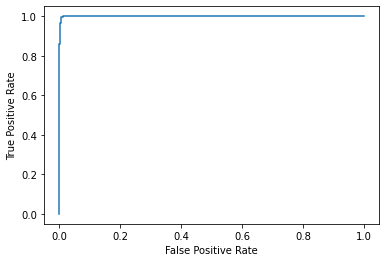

In [66]:
from sklearn.metrics import roc_curve

probs = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  probs)

plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [44]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1643
           1       0.99      1.00      0.99      1643

    accuracy                           0.99      3286
   macro avg       0.99      0.99      0.99      3286
weighted avg       0.99      0.99      0.99      3286



In [45]:
from xgboost import plot_importance

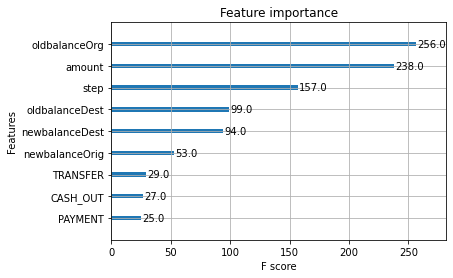

In [46]:
plot_importance(model)
plt.show()